In [1]:
%load_ext autoreload
%autoreload 3

In [2]:
from pathlib import Path

import pandas as pd
import torch
from transformers import LayoutLMv3ForTokenClassification

from mozilla_sec_eia.finetune_ex21_extractor import LayoutLMExtractor
from mozilla_sec_eia.create_labeled_dataset import format_as_ner_annotations
from mozilla_sec_eia.pdf_text_extraction_utils import unnormalize_box, draw_boxes_on_img, iob_to_label

/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [3]:
checkpoint_path = "layoutlm_v1_50_labeled_docs/checkpoint-1000"

In [4]:
ner_annotations = format_as_ner_annotations()

In [5]:
extractor = LayoutLMExtractor.from_ner_annotations(ner_annotations, model_path=checkpoint_path)

/Users/katielamb/CatalystCoop/mozilla-sec-eia/src/mozilla_sec_eia/finetune_ex21_extractor.py:51: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  self.metric = load_metric("seqeval")
/Users/katielamb/mambaforge/envs/mozilla-sec-eia/lib/python3.11/site-packages/datasets/load.py:759: FutureWarning: The repository for seqeval contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.19.1/metrics/seqeval/seqeval.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


Map:   0%|          | 0/40 [00:00<?, ? examples/s]

Map:   0%|          | 0/10 [00:00<?, ? examples/s]

In [159]:
example["id"]

'100826-2009q1-100826-0001193125-09-042636'

In [151]:
example = extractor.dataset["train"][14]
example.keys()

dict_keys(['id', 'tokens', 'ner_tags', 'bboxes', 'image'])

In [152]:
image = example["image"]
words = example["tokens"]
boxes = example["bboxes"]
ner_tags = extractor._convert_ner_tags_to_id(example["ner_tags"])

encoding = extractor.processor(image, words, boxes=boxes, word_labels=ner_tags, return_tensors="pt")
for k,v in encoding.items():
    print(k,v.shape)

input_ids torch.Size([1, 387])
attention_mask torch.Size([1, 387])
bbox torch.Size([1, 387, 4])
labels torch.Size([1, 387])
pixel_values torch.Size([1, 3, 224, 224])


In [153]:
encoding["input_ids"] = encoding["input_ids"].to(torch.int64)
encoding["attention_mask"] = encoding["attention_mask"].to(torch.int64)
encoding["labels"] = encoding["labels"].to(torch.int64)
encoding["bbox"] = encoding["bbox"].to(torch.int64)

In [154]:
with torch.no_grad():
    outputs = extractor.model(**encoding)

In [155]:
logits = outputs.logits
predictions = logits.argmax(-1).squeeze().tolist()
labels = encoding.labels.squeeze().tolist()

In [156]:
token_boxes = encoding.bbox.squeeze().tolist()
width, height = image.size

true_predictions = [extractor.model.config.id2label[pred] for pred, label in zip(predictions, labels) if label != - 100]
true_labels = [extractor.model.config.id2label[label] for prediction, label in zip(predictions, labels) if label != -100]
true_boxes = [unnormalize_box(box, width, height) for box, label in zip(token_boxes, labels) if label != -100]

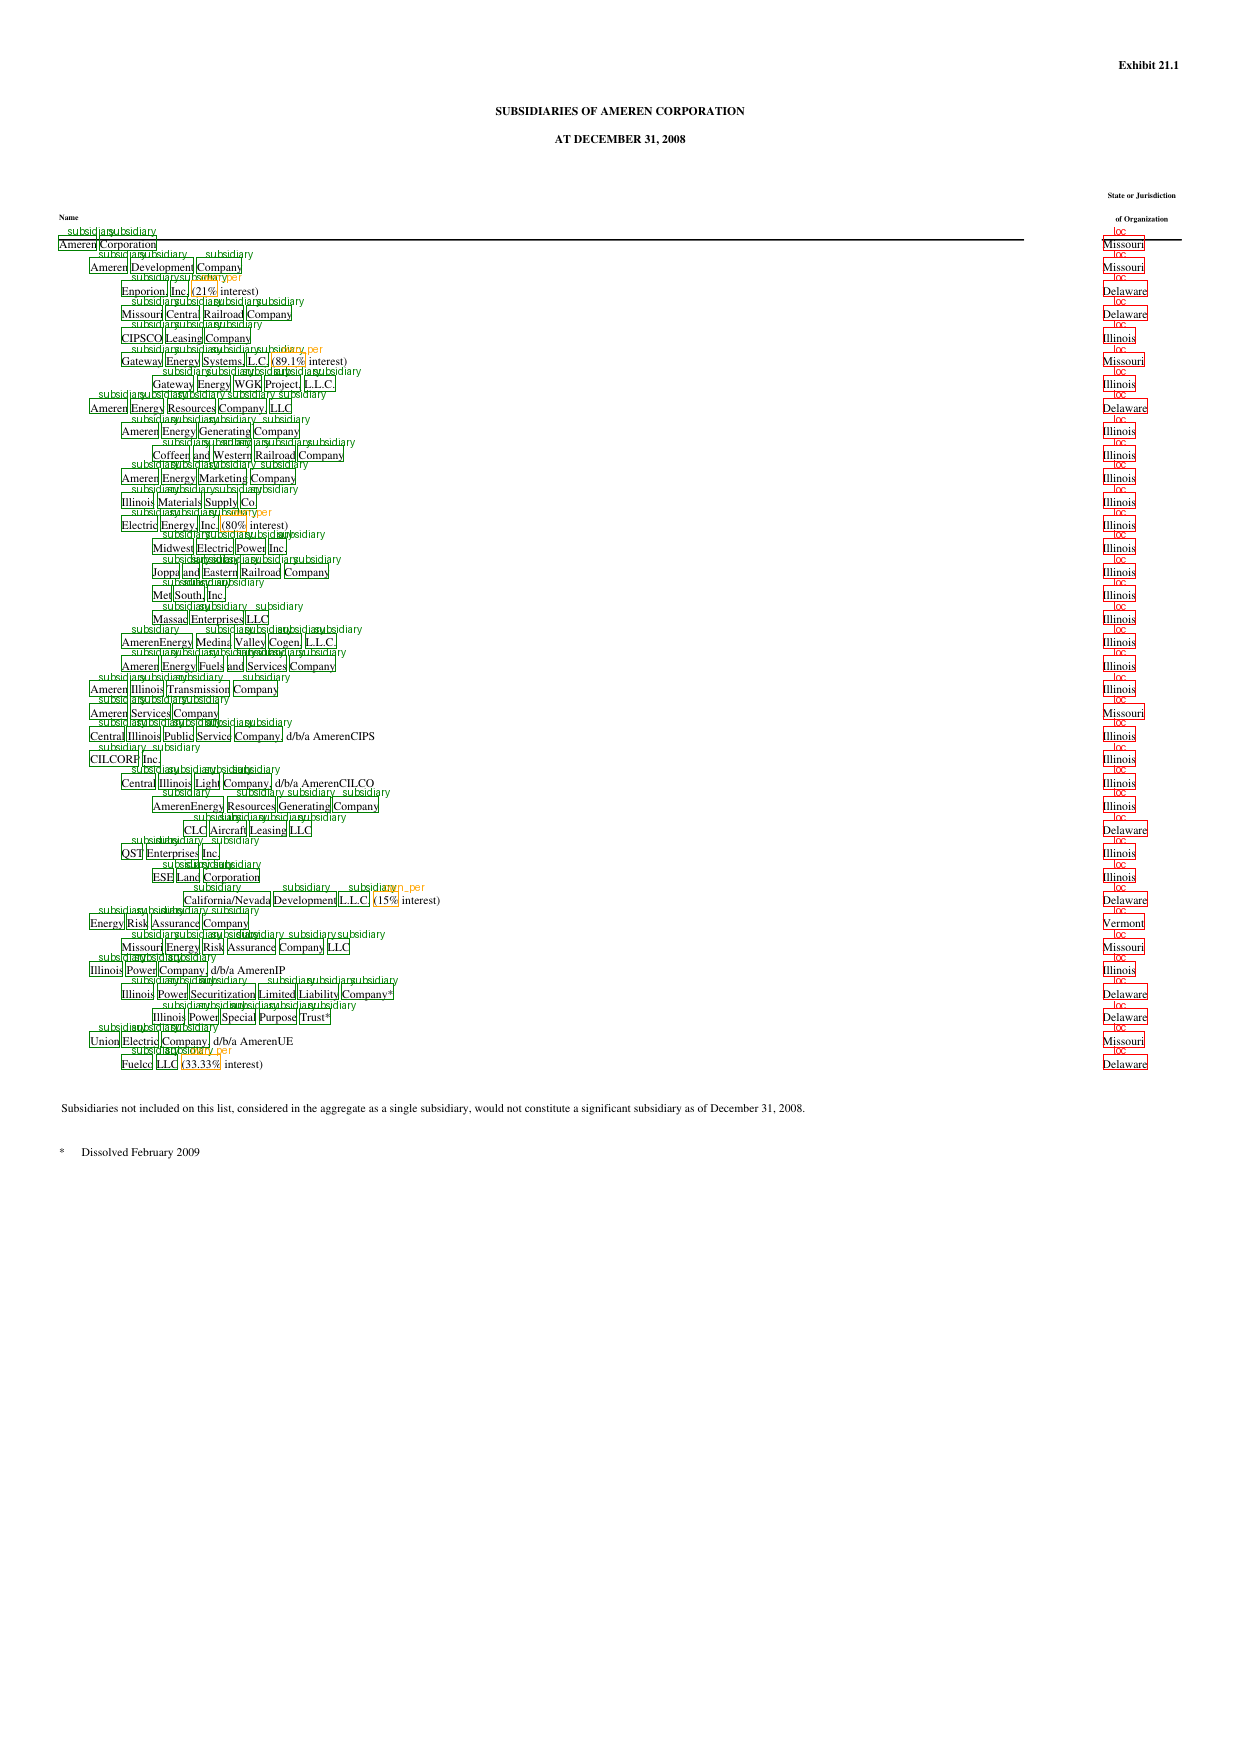

In [157]:
image = example["image"]
image = image.convert("RGB")

draw_boxes_on_img(true_predictions, true_boxes, image)
image

In [158]:
image.save("ameren_corporation.png")

# Extract into a table

In [49]:
len(words), len(boxes), len(ner_tags)

(237, 237, 237)

In [59]:
# true boxes is the unnormalized version of boxes
len(true_predictions), len(true_labels), len(true_boxes)

(237, 237, 237)

In [76]:
true_predictions[100], true_labels[100]

('I-Subsidiary', 'I-Subsidiary')

In [60]:
len(labels), len(predictions)

(387, 387)

In [86]:
simple_labels = []
for label in true_predictions:
    simple_labels.append(iob_to_label(label).lower())

In [66]:
# can also just generate this dataframe from the PDF text extraction functions
# and then merge on the label
doc_df = pd.DataFrame(data=boxes, columns=["top_left_x", "top_left_y", "bottom_right_x", "bottom_right_y"])

In [87]:
doc_df.loc[:, "word"] = words
doc_df.loc[:, "label"] = simple_labels

In [89]:
# probably need some tolerance here
rows_df = doc_df.sort_values(by="top_left_x").groupby(["top_left_y", "label"])["word"].apply(" ".join).reset_index()

In [96]:
rows_df = rows_df[rows_df.label != "other"]

In [97]:
extracted_df = rows_df.pivot_table(index='top_left_y', columns='label', values='word', aggfunc=lambda x: ' '.join(x)).reset_index()

In [100]:
extracted_df = extracted_df.drop(columns=["top_left_y"])

In [109]:
extracted_df

label,loc,own_per,subsidiary
index,,,
0,Missouri,NaN,Ameren Corporation
1,Missouri,NaN,Ameren Development Company
2,Delaware,(21%,"Enporion, Inc."
3,Delaware,NaN,Missouri Central Railroad Company
4,Illinois,NaN,CIPSCO Leasing Company
5,Missouri,(89.1%,"Gateway Energy Systems, L.C."
6,Illinois,NaN,"Gateway Energy WGK Project, L.L.C."
7,Delaware,NaN,"Ameren Energy Resources Company, LLC"
8,Illinois,NaN,Ameren Energy Generating Company


In [119]:
extracted_df["own_per"] = extracted_df['own_per'].str.replace('[^\w.]', '', regex=True)

In [120]:
extracted_df

label,loc,own_per,subsidiary
index,,,
0,Missouri,NaN,Ameren Corporation
1,Missouri,NaN,Ameren Development Company
2,Delaware,21,"Enporion, Inc."
3,Delaware,NaN,Missouri Central Railroad Company
4,Illinois,NaN,CIPSCO Leasing Company
5,Missouri,89.1,"Gateway Energy Systems, L.C."
6,Illinois,NaN,"Gateway Energy WGK Project, L.L.C."
7,Delaware,NaN,"Ameren Energy Resources Company, LLC"
8,Illinois,NaN,Ameren Energy Generating Company
